### Notes:
Everytime a user tries to predict a bandgap, I want to do the following:
1. check if there are any .csv files in data directory that have not been converted to json files; if so, convert them
2. User can input new training data using the TrainingData class
3. create a new training data set based on the formula and parameters input by the user
    - should I only train w/ compounds containing the elements in the input? 
        - I don't think so, because there are structural related aspects to the prediction as well
    - But I should only train w/ the parameters input by the user
4. train the model
5. predict the bandgap

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [2]:
import sys
sys.path.insert(1, "../src/")
from trainingdata import TrainingData
from bandgapdataset import BandGapDataset
from periodictable import PeriodicTable
from bandgapdataframe import BandGapDataFrame

### TrainingData class 
- allows user to input and save training data in correct json format

In [3]:
test_training_data = TrainingData("SiGe")
test_training_data.band_gap = 1.2
test_training_data.show_data()

{'user-26015': {'formula': 'SiGe', 'spacegroup': '', 'formation_energy__eV': 0.0, 'E_above_hull__eV': 0.0, 'band_gap__eV': 1.2, 'has_bandstructure': False, 'volume': 0.0, 'Nsites': 0, 'theoretical': False, 'count': 0.0, 'density__gm_per_cc': 0.0, 'crystal_system': ''}}


In [4]:
# would use this to store user-input data
#test_training_data.store_data()

### BandGapDataset class
- creates object which contains stored data as a dictionary

In [5]:
csv_path = "../data/training/materialsproject_output/"
json_path = "../data/training/materialsproject_json/"

dataset = BandGapDataset(csv_path,json_path)
data_dict = dataset.data_dict
data_IDs = dataset.data_IDs

In [6]:
data_dict[data_IDs[-1]]

{'formula': 'ZnTe',
 'spacegroup': 'Fm3m',
 'formation_energy__eV': -0.185,
 'E_above_hull__eV': 0.289,
 'band_gap__eV': 0.0,
 'has_bandstructure': True,
 'volume': 48.038000000000004,
 'Nsites': 2,
 'theoretical': False,
 'count': nan,
 'density__gm_per_cc': 6.672000000000001,
 'crystal_system': 'cubic',
 'stoichiometry': {'Zn': 0.5, 'Te': 0.5}}

### PeriodicTable class
- creates object which contains the periodic table json from exabyte.io's github
- houses map from symbol to element
- houses list of symbols

In [7]:
periodic_table = PeriodicTable()
symbol_to_element_map = periodic_table.symbol_to_element_map
symbols = periodic_table.symbols

### BandGapDataframe class
The dataframe contains the following:
1. Stoichiomery
2. Bandgap
3. Density 
4. Volume
5. Formation energy

In [12]:
bandgap_dataframe = BandGapDataFrame(data_dict, symbols)
dataframe = bandgap_dataframe.dataframe
non_element_keys = bandgap_dataframe.non_element_keys

In [11]:
dataframe.sample(5)

,ID,band_gap__eV,density__gm_per_cc,volume,formation_energy__eV,H,He,Li,Be,B,...,Mt,Uun,Uuu,Uub,Uut,Uuq,Uup,Uuh,Uus,Uuo
1076,mp-1217135,0.000,5.221,76.164,-2.442,0,0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1132,mp-656850,1.183,1.995,345.816,-1.840,0,0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
914,mp-949028,0.733,4.796,1890.621,0.012,0,0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1229,mp-773019,0.537,3.389,526.855,-2.290,0,0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
555,mp-1079020,0.000,6.152,156.852,0.308,0,0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0


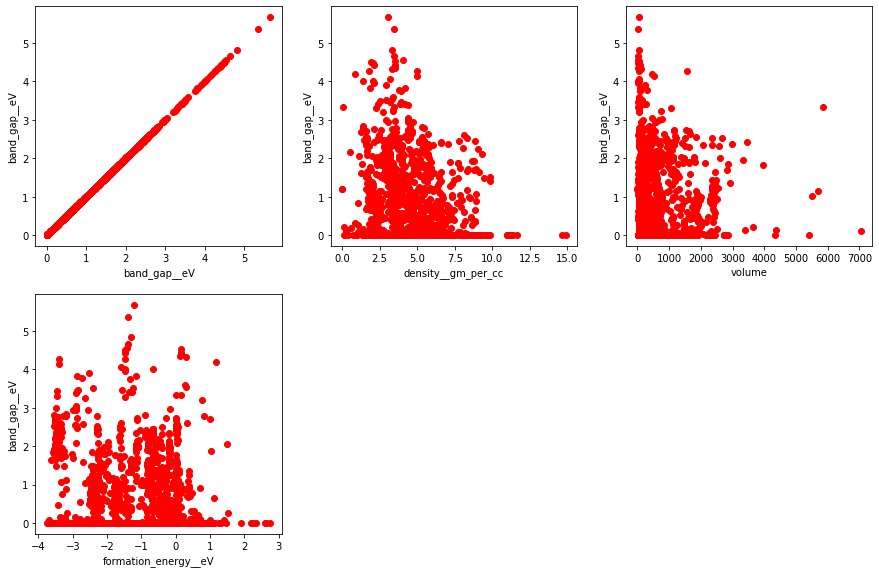

In [13]:
rcParams['figure.figsize'] = 15,15
rows, cols = 3, 3

yaxis = dataframe['band_gap__eV']
for idx, key in enumerate(non_element_keys):
    xaxis = dataframe[key]

    plt.subplot(rows,cols,idx+1)
    plt.plot(xaxis, yaxis, "ro")
    plt.xlabel(key)
    plt.ylabel('band_gap__eV')
    
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

In [63]:
X_keys = list(training_data_clean_df.keys())[2:]
X = np.asarray(training_data_clean_df[X_keys])
#X = np.asarray(training_data_clean_df[["density__gm_per_cc","formation_energy__eV","volume"]])
y = np.asarray(training_data_clean_df['band_gap__eV'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle= True)

In [64]:
print(f"X_train shape: {np.shape(X_train)}")
print(f"y_train shape: {np.shape(y_train)}")
print(f" X_test shape: {np.shape(X_test)}")
print(f" y_test shape: {np.shape(y_test)}")

X_train shape: (41, 122)
y_train shape: (41,)
 X_test shape: (21, 122)
 y_test shape: (21,)


In [75]:
X_train[0]

array([ 2.158, 86.428,  0.101,  3.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
      

Score:  0.5927355497551119
Weights:  [-2.60421139e-01  6.48405785e-05 -7.19734539e-01  4.54134323e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.92697590e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.92697590e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.0

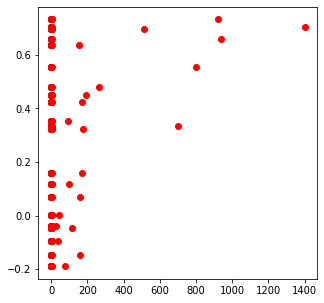

In [71]:
model = linear_model.Ridge(alpha = .5)
model.fit(X_train, y_train)
print('Score: ', model.score(X_test, y_test))
print('Weights: ', model.coef_)

predictions = model.predict(X_test)

plt.plot(X_test, predictions, "ro")
plt.show()

In [72]:
predictions

array([-0.0942805 ,  0.00140731, -0.0480738 ,  0.32415098,  0.33560988,
        0.6977741 ,  0.15845846,  0.42384861,  0.55661068,  0.11977226,
        0.73280628,  0.4496829 ,  0.63780905, -0.03794238, -0.14600555,
        0.07073982,  0.70421831,  0.66019909,  0.47904858, -0.18979685,
        0.35404814])

In [73]:
X_test

array([[6.22300e+00, 3.87670e+01, 3.26000e-01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [3.25800e+00, 4.29380e+01, 5.16000e-01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [3.19200e+00, 1.16893e+02, 4.26000e-01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [2.12200e+00, 2.63713e+02, 9.40000e-02, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [6.21200e+00, 7.76650e+01, 3.40000e-01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [5.08200e+00, 9.49440e+01, 1.21000e-01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [15]:
sample = training_data[training_data_IDs[-1]]
sample_atoms = list(sample["stoichiometry"].keys())
print(sample_atoms)
sample_atoms_elements = [ symbol_to_element_map[sample_atom] for sample_atom in sample_atoms ]
print(sample_atoms_elements)

['Si', 'Ge']
['Silicon', 'Germanium']


In [16]:
periodic_table[sample_atoms_elements[0]]

{'symbol': 'Si',
 'atomic_number': 14,
 'atomic_weight': 28.0855,
 'density_g_per_cm3': 2.33,
 'melting_point_K': 1683,
 'boiling_point_K': 2628,
 'atomic_radius_pm': 132,
 'covalent_radius_pm': 111,
 'ionic_radius_pm': '',
 'atomic_volume_cm3_per_mol': 12.1,
 'specific_heat_J_g_mol': 0.703,
 'fusion_heat_kJ_mol': 50.6,
 'evaporation_heat_kJ_mol': 383,
 'thermal_conductivity_25C_W_m_K': 149,
 'pauling_negativity': 1.9,
 'first_ionizing_kJ_mol': 786,
 'oxidation_states': '4, -4',
 'electronic_configuration': '[Ne]3s²3p²',
 'lattice_structure': 'DIA',
 'lattice_constant_ang': 5.43}

In [ ]:
# change crystal system to an identification number
crystal_systems = [
    "triclinic",
    "monoclinic",
    "orthorhombic",
    "tetragonal",
    "hexagonal",
    "trigonal",
    "cubic",
]
crystal_system_mapping = dict(zip(crystal_systems, range(0,len(crystal_systems))))